# LAB 4
# The short guide into the parameter sensitivity analysis (PSA) workflow. 

## Site specific case

Our current sensitivity analysis frmework includes two main types of the sensitivity analysis: input sensitivity analysis (ISA) and parameter sensitivity analysis (PSA). Here we cover PSA only. 

Author: Elchin Jafarov & Tobey Carman

Date: 02/23/2022

### 1. SA Instantiation

In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4 as nc
import seaborn as sns

import Sensitivity
import param_util as pu

Lets get started by making a driver object and print out some info about it.
The **workdir** is a folder that will include all the current runs. Each sample generated as a results of SA will include be stored in the separate folder and include all the required input and output files to run the correspoding sample case. Each sample represents the a row from the sample matrix. For example, sample_0..0 represents row one from the sample matrix. 

In [2]:
driver = Sensitivity.SensitivityDriver()
print(driver.info())

--- Setup ---
work_dir: /data/workflows/sensitivity_analysis
site: /data/input-catalog/cru-ts40_ar5_rcp85_ncar-ccsm4_CALM_Toolik_LTER_10x10/
pixel(y,x): (0,0)
cmtnum: None
pftnum: None ()
setup : -p 5 -e 5 -s 5 -t 5 -n 5

--- Parameters ---
[not set]

--- Sample Matrix ---
sample_matrix shape: [not set]

--- Outputs ---
> NOTE - these may be leftover from a prior run!
found 0 existing sensitivity csv files.




Below we modify the input datasets and change the "run stages". More info on the "run stages" is needed. Run `ls $driver.site` to see all input files.

In [3]:
driver.site='/data/input-catalog/cru-ts40_ar5_rcp85_mri-cgcm3_EML_study_area_10x10'
driver.opt_run_setup = '-p 5 -e 5 -s 5 -t 5 -n 5'

The `SensitivtyDriver` object is designed to help setup and conduct a sensitivity analysis. There are some hard-coded assumptions in the driver object (which pixel to run, the input dataset/site to use, the source of the initial parameter values, which outputs to process and the location of the working directory). The driver object is configurable with respect to the parameters to be used in the sensitivity analysis, the bounds for the parameters, which PFT to analyze, and which CMT (community type) to run.

Let's design our experiment. We need assign number of smaples, select desired parameters, choose percent variance from the initial value, and sampling method. Currently we have two sampling methods available to us: latin hypercube ([lhs](https://en.wikipedia.org/wiki/Latin_hypercube_sampling)) and [uniform sampling](https://numpy.org/doc/stable/reference/random/generated/numpy.random.uniform.html). 

### 2. SA setup
We set up the sample_matrix based on:
1. looking up the initial values from dvmdostem parameter files (cmt_*.txt), and
2. setting up the bounds based on those initial values plus/minus the percent diffs.

> Need a better name for `percent_diffs` - these are the % range that the bounds will be set around the initial value. Right now it defaults to +/-10% if the `percent_diffs` array is not passed.

In [4]:
# setup parameters: 
# Nsamples: number of sample points in the parameter interval
# cmtnum: community type number (site specific)
# params: list of parameter names
# pftnums: list, pft numbers marked by 0 and non pfts by None
# percent_diffs: the difference from the initial value (i.e. initial_value +- initial_value*percent)
# sampling_method: currently only two: lhs and uniform
driver.design_experiment(Nsamples=10, cmtnum=4, params=['cmax','rhq10','nmax'], 
                         pftnums=[0,None,0], percent_diffs=[.1, .1, 0.1],
                         sampling_method='lhc')
print(driver.info())

Sampling method: lhc
--- Setup ---
work_dir: /data/workflows/sensitivity_analysis
site: /data/input-catalog/cru-ts40_ar5_rcp85_mri-cgcm3_EML_study_area_10x10
pixel(y,x): (0,0)
cmtnum: 4
pftnum: 0 (Salix)
setup : -p 5 -e 5 -s 5 -t 5 -n 5

--- Parameters ---
    name          bounds  initial  cmtnum pftnum
0   cmax  [189.0, 231.0]      210       4    0.0
1  rhq10      [1.8, 2.2]        2       4       
2   nmax      [5.4, 6.6]        6       4    0.0

--- Sample Matrix ---
sample_matrix shape: (10, 3)

--- Outputs ---
> NOTE - these may be leftover from a prior run!
found 0 existing sensitivity csv files.




Now we need to specify the output data. Outputing all generated by the model results might take a lot of storage space. Here we specify outputs that we are most interested in. 

In [18]:
#setup outputs
# the 'type' could be left empty for outputs without layers
# e.g. NPP is a timeseries, VWCLAYER is a layered from timeseries (from multiple depth)
print('Setting up the outputs...')
driver.outputs=[]
driver.outputs.append({'name': 'ALD', 'type': 'xxx'})
driver.outputs.append({'name': 'NPP', 'type': 'xxx'})
driver.outputs.append({'name': 'RAINFALL', 'type': 'xxx'})
driver.outputs.append({'name': 'SNOWTHICK', 'type': 'xxx'})
driver.outputs.append({'name': 'VEGC', 'type': 'xxx'})
driver.outputs.append({'name': 'VWCLAYER', 'type': 'layer'})
driver.outputs.append({'name': 'WATERTAB', 'type': 'xxx'})
driver.outputs.append({'name': 'TLAYER', 'type': 'layer'})
driver.outputs

Setting up the outputs...


[{'name': 'ALD', 'type': 'xxx'},
 {'name': 'NPP', 'type': 'xxx'},
 {'name': 'RAINFALL', 'type': 'xxx'},
 {'name': 'SNOWTHICK', 'type': 'xxx'},
 {'name': 'VEGC', 'type': 'xxx'},
 {'name': 'VWCLAYER', 'type': 'layer'},
 {'name': 'WATERTAB', 'type': 'xxx'},
 {'name': 'TLAYER', 'type': 'layer'}]

### 3. SA create sampling folder
The function below creates the `Nsample` number of folder. Each folder includes input dataset with the modified set of parameteres from the sample matrix. 

In [19]:
try:
    driver.setup_multi()
except ValueError:
    print("Oops!  setup_multi failed.  Check the setup...")

PROC:<ForkProcess name='ForkPoolWorker-7' parent=6133 started daemon>  PROC:<ForkProcess name='ForkPoolWorker-8' parent=6133 started daemon>  PROC:<ForkProcess name='ForkPoolWorker-9' parent=6133 started daemon>     {'cmax': 207.23247867441108, 'rhq10': 2.123724110712236, 'nmax': 6.197043797538514}{'cmax': 213.88371319676997, 'rhq10': 2.1960167222865334, 'nmax': 6.499395445691354}{'cmax': 227.27658878921048, 'rhq10': 1.8358886303181332, 'nmax': 6.370096795799405}

[SA:setup] /work/scripts/setup_working_directory.py --input-data-path /data/input-catalog/cru-ts40_ar5_rcp85_mri-cgcm3_EML_study_area_10x10 /data/workflows/sensitivity_analysis/sample_000000000[SA:setup] /work/scripts/setup_working_directory.py --input-data-path /data/input-catalog/cru-ts40_ar5_rcp85_mri-cgcm3_EML_study_area_10x10 /data/workflows/sensitivity_analysis/sample_000000002


[SA:setup] /work/scripts/setup_working_directory.py --input-data-path /data/input-catalog/cru-ts40_ar5_rcp85_mri-cgcm3_EML_study_area_10x10 /d


[SA:setup] /work/scripts/outspec_utils.py /data/workflows/sensitivity_analysis/sample_000000000/config/output_spec.csv --on VWCLAYER m p l

[SA:setup] /work/scripts/outspec_utils.py /data/workflows/sensitivity_analysis/sample_000000002/config/output_spec.csv --on WATERTAB m p

[SA:setup] /work/scripts/outspec_utils.py /data/workflows/sensitivity_analysis/sample_000000001/config/output_spec.csv --on WATERTAB m p

[SA:setup] /work/scripts/outspec_utils.py /data/workflows/sensitivity_analysis/sample_000000000/config/output_spec.csv --on WATERTAB m p

[SA:setup] /work/scripts/outspec_utils.py /data/workflows/sensitivity_analysis/sample_000000002/config/output_spec.csv --on TLAYER m p l

[SA:setup] /work/scripts/outspec_utils.py /data/workflows/sensitivity_analysis/sample_000000001/config/output_spec.csv --on TLAYER m p l

[SA:setup] /work/scripts/outspec_utils.py /data/workflows/sensitivity_analysis/sample_000000000/config/output_spec.csv --on TLAYER m p l
                Name            


[SA:setup] /work/scripts/outspec_utils.py /data/workflows/sensitivity_analysis/sample_000000003/config/output_spec.csv --on CMTNUM y


[SA:setup] /work/scripts/outspec_utils.py /data/workflows/sensitivity_analysis/sample_000000004/config/output_spec.csv --on CMTNUM y

                Name                Units       Yearly      Monthly        Daily          PFT Compartments       Layers    Data Type     Description
              TLAYER             degree_C            y            m      invalid      invalid      invalid            l       double     Temperature by layer
                Name                Units       Yearly      Monthly        Daily          PFT Compartments       Layers    Data Type     Description
              CMTNUM                    m            y      invalid      invalid      invalid      invalid      invalid          int     Community Type Number
                Name                Units       Yearly      Monthly        Daily          PFT Compartments       La



[SA:setup] /work/scripts/outspec_utils.py /data/workflows/sensitivity_analysis/sample_000000008/config/output_spec.csv --on VEGC m p[SA:setup] /work/scripts/outspec_utils.py /data/workflows/sensitivity_analysis/sample_000000007/config/output_spec.csv --on VEGC m p


[SA:setup] /work/scripts/outspec_utils.py /data/workflows/sensitivity_analysis/sample_000000006/config/output_spec.csv --on WATERTAB m p

[SA:setup] /work/scripts/outspec_utils.py /data/workflows/sensitivity_analysis/sample_000000008/config/output_spec.csv --on VWCLAYER m p l

[SA:setup] /work/scripts/outspec_utils.py /data/workflows/sensitivity_analysis/sample_000000007/config/output_spec.csv --on VWCLAYER m p l

[SA:setup] /work/scripts/outspec_utils.py /data/workflows/sensitivity_analysis/sample_000000006/config/output_spec.csv --on TLAYER m p l
                Name                Units       Yearly      Monthly        Daily          PFT Compartments       Layers    Data Type     Description
           SNOWTHICK       


[SA:setup] /work/scripts/outspec_utils.py /data/workflows/sensitivity_analysis/sample_000000009/config/output_spec.csv --on SNOWTHICK m p

[SA:setup] /work/scripts/outspec_utils.py /data/workflows/sensitivity_analysis/sample_000000009/config/output_spec.csv --on VEGC m p

[SA:setup] /work/scripts/outspec_utils.py /data/workflows/sensitivity_analysis/sample_000000009/config/output_spec.csv --on VWCLAYER m p l
                Name                Units       Yearly      Monthly        Daily          PFT Compartments       Layers    Data Type     Description
            RAINFALL                   mm            y            m      invalid      invalid      invalid      invalid       double     Total rainfall
                Name                Units       Yearly      Monthly        Daily          PFT Compartments       Layers    Data Type     Description
           SNOWTHICK                    m            y            m                   invalid      invalid      invalid       double     

### 4. SA run
We run each sample separately in its own folder. The run is happening in parallel and is using python's multiprocessing function. 

In [21]:
try:
    driver.run_all_samples()
except ValueError:
    print("Oops!  run_all_samples failed.  Check the sample folders...")

[SA:run] /work/dvmdostem -p 5 -e 5 -s 5 -t 5 -n 5 -l err --force-cmt 4 --ctrl-file /data/workflows/sensitivity_analysis/sample_000000001/config/config.js[SA:run] /work/dvmdostem -p 5 -e 5 -s 5 -t 5 -n 5 -l err --force-cmt 4 --ctrl-file /data/workflows/sensitivity_analysis/sample_000000000/config/config.js
[SA:run] /work/dvmdostem -p 5 -e 5 -s 5 -t 5 -n 5 -l err --force-cmt 4 --ctrl-file /data/workflows/sensitivity_analysis/sample_000000002/config/config.js


[SA:run] /work/dvmdostem -p 5 -e 5 -s 5 -t 5 -n 5 -l err --force-cmt 4 --ctrl-file /data/workflows/sensitivity_analysis/sample_000000003/config/config.js

[SA:run] /work/dvmdostem -p 5 -e 5 -s 5 -t 5 -n 5 -l err --force-cmt 4 --ctrl-file /data/workflows/sensitivity_analysis/sample_000000004/config/config.js

[SA:run] /work/dvmdostem -p 5 -e 5 -s 5 -t 5 -n 5 -l err --force-cmt 4 --ctrl-file /data/workflows/sensitivity_analysis/sample_000000005/config/config.js

[SA:run] /work/dvmdostem -p 5 -e 5 -s 5 -t 5 -n 5 -l err --force-cmt 4 -

In [20]:
#for book keeping purposes it is good to save the sample matrix into the workdir 
#save the sample matrix in the same folder
driver.save_experiment(driver.work_dir+'/')

Saving /data/workflows/sensitivity_analysis/_sample_matrix.csv
Saving /data/workflows/sensitivity_analysis/_param_props.csv


### 5. SA output visualization

In [22]:
def get_output_var_size(fdir,oname):   
    filename = fdir+item+'/output/'+oname+'_monthly_tr.nc'
    stg_data = nc.Dataset(filename, 'r')
    print('{} dim:',oname,len(stg_data.dimensions))

def get_samples(fdir,oname):
    #make a list of all output files  
    
    fname = oname+'_monthly_tr.nc'
    fsamples = []
    for item in os.listdir(fdir):
        if item[:6]=='sample':
            fsamples.append(fdir+item+'/output/'+fname)
    fsamples.sort()

    return fsamples

def get_output_var_size(fdir,oname):   
    filename = fdir+item+'/output/'+oname+'_monthly_tr.nc'
    stg_data = nc.Dataset(filename, 'r')
    print(oname,'dim:',len(stg_data.dimensions))

    
def plot3D_last_year_ts(fdir,oname):
    '''
    Input:
        fdir: path to the sensitivity analysis directory (workdir)
        oname: output name
    Output:
        df1: dataframe of oname time series for tr run
    '''
    fsamples = get_samples(fdir,oname)
    #get the 'oname' variable time series from the correspoding output nc files  
    stg_data = nc.Dataset(fsamples[0], 'r')
    #print(stg_data.shape)
    
    df1 = pd.DataFrame(stg_data.variables[oname][-12:,0,0], columns=[oname+'_0'])   
    for i in range(1,len(fsamples)):
        stg_data = nc.Dataset(fsamples[i], 'r')
        df2 = pd.DataFrame(stg_data.variables[oname][-12:,0,0], columns=[oname+'_'+str(i)])
        df1 = df1.join(df2)
    df1 = df1.set_index(pd.Series(pd.period_range("1/15/2011", freq="M", periods=12)))
    return df1

def plot4D_last_year_ts(fdir,oname,idx=4):
    '''
    Input:
        fdir: path to the sensitivity analysis directory (workdir)
        oname: output name
        idx: layer or pft number
    Output:
        df1: dataframe of oname time series for tr run
    '''

    fsamples = get_samples(fdir,oname)
    
    #get the 'oname' variable time series from the correspoding output nc files  
    stg_data = nc.Dataset(fsamples[0], 'r')
    
    df1 = pd.DataFrame(stg_data.variables[oname][-12:,idx,0,0], columns=[oname+'_0'])   
    for i in range(1,len(fsamples)):
        stg_data = nc.Dataset(fsamples[i], 'r')
        df2 = pd.DataFrame(stg_data.variables[oname][-12:,idx,0,0], columns=[oname+'_'+str(i)])
        df1 = df1.join(df2)
    df1 = df1.set_index(pd.Series(pd.period_range("1/15/2011", freq="M", periods=12)))
    return df1

#get the outputs
fdir=driver.work_dir+'/'
vegc = plot4D_last_year_ts(fdir,'VEGC',4)
gpp = plot4D_last_year_ts(fdir,'GPP',4)
rainfall = plot3D_last_year_ts(fdir,'RAINFALL')
snowthink = plot3D_last_year_ts(fdir,'SNOWTHICK')
vwclayer = plot4D_last_year_ts(fdir,'VWCLAYER',4)
watertab = plot3D_last_year_ts(fdir,'WATERTAB')
tlayer = plot4D_last_year_ts(fdir,'TLAYER',4)

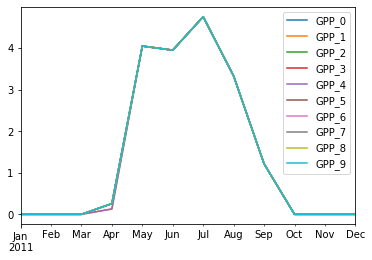

In [23]:
#plot gpp
gpp.plot( )

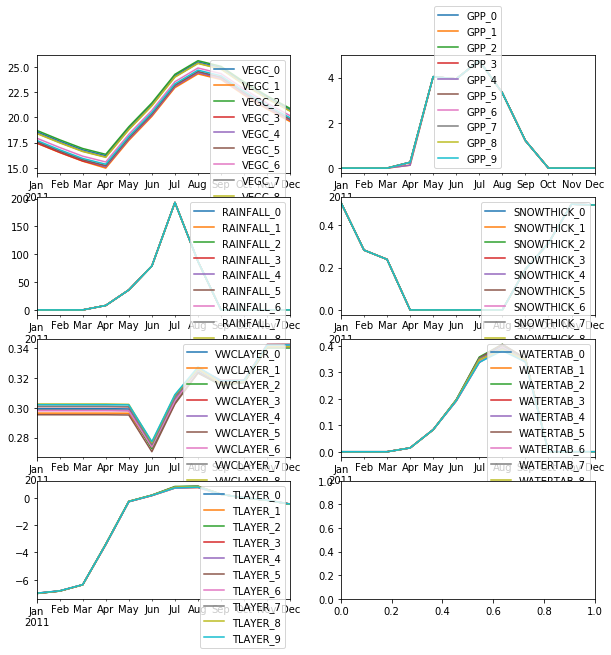

In [24]:
#visualize all the ouputs
figure, axes = plt.subplots(4,2,figsize=(10,10))
vegc.plot( ax=axes[0,0])
gpp.plot( ax=axes[0,1])
rainfall.plot( ax=axes[1,0])
snowthink.plot( ax=axes[1,1])
vwclayer.plot( ax=axes[2,0])
watertab.plot( ax=axes[2,1])
tlayer.plot( ax=axes[3,0])

In [15]:
#make a joined params outputs matrix
#take mean annual values (n: samples, n: MAVs)
df_sample_matrix= pd.read_csv(fdir+'_sample_matrix.csv')  

output_matrix=np.zeros((df_sample_matrix.shape[0], 7))
output_matrix[:,0]=vegc.mean().values
output_matrix[:,1]=gpp.mean().values
output_matrix[:,2]=rainfall.mean().values
output_matrix[:,3]=snowthink.mean().values
output_matrix[:,4]=vwclayer.mean().values
output_matrix[:,5]=watertab.mean().values
output_matrix[:,6]=tlayer.mean().values

df_output_matrix=pd.DataFrame(output_matrix, 
                           columns=["vegc", "gpp", "rainfall", "snowthick",
                                    "vwclayer","watertab","tlayer"])

df_sample_matrix = df_sample_matrix.join(df_output_matrix)
df_sample_matrix.head()

,cmax,rhq10,nmax,vegc,gpp,rainfall,snowthick,vwclayer,watertab,tlayer
0,207.232479,2.123724,6.197044,0.653416,1.461969,33.550749,0.211404,0.309424,0.116615,-1.865248
1,227.276589,1.835889,6.370097,0.632950,1.450606,33.550749,0.211437,0.308816,0.113743,-1.887243
2,213.883713,2.196017,6.499395,0.656125,1.461946,33.550749,0.211414,0.308608,0.117694,-1.861425
3,205.284825,1.985324,6.107827,0.634838,1.461929,33.550749,0.211405,0.310983,0.113978,-1.873958
4,219.483355,1.853561,5.472771,0.635535,1.450842,33.550749,0.211424,0.310046,0.112953,-1.883291


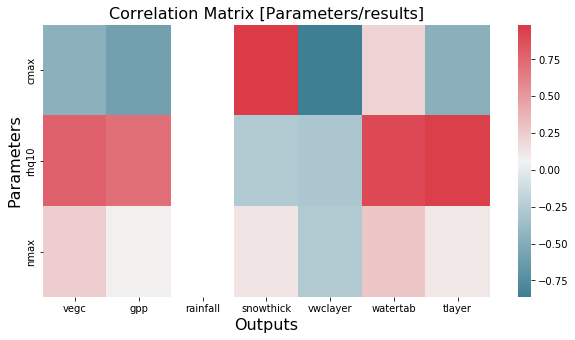

In [16]:
#visualize the correlation of a sample matrix
nparams=3
corr=df_sample_matrix.corr()
plt.figure(figsize=(10,5))
sns.heatmap(corr.iloc[0:nparams,nparams:], 
            cmap=sns.diverging_palette(220, 10, as_cmap=True))
plt.title('Correlation Matrix [Parameters/results]',fontsize=16);
plt.ylabel('Parameters',fontsize=16)
plt.xlabel('Outputs',fontsize=16);

Text(0, 0.5, 'snowthick')

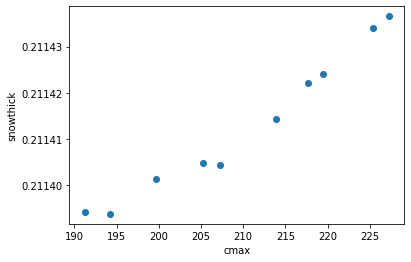

In [17]:
#let's study some weird correlations
plt.plot(df_sample_matrix['cmax'],df_sample_matrix['snowthick'],'o')
plt.xlabel('cmax')
plt.ylabel('snowthick')

### Exercises: 
1. plot couple other variables from the correlation matrix (for example 'cmax','tlayer' and 'rhq10', 'wvclayer')
2. what can you tell about those correlations
3. increase the percent_diffs=[.1, .1, 0.1] from 10% to 25%
4. change the sampling_method='lhc' to 'uniform'. Compare the resutls with 'lhc' and 'uniform'.
5. increase the sample size. 

#### Extra:
6. add another parameter to the list params=['cmax','rhq10','nmax'] 
